## Setup

In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")

In [2]:
from nnsight.models.UnifiedTransformer import UnifiedTransformer, LanguageModel
import torch.nn.functional as F
import torch as th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from pathlib import Path
from time import time
import itertools

th.set_grad_enabled(False)

In [3]:
model = "meta-llama/Meta-Llama-3-70B"
dlabscratch = Path("/dlabscratch1/dlabscratch1")
model_path = dlabscratch / "public/llm_weights/llama3_hf/Meta-Llama-3-70B/"
check_translation_performance = False
batch_size = 16
thinking_langs = ["en"]
to_langs = ["de", "en", "fr"]
from_langs = ["de", "en", "fr", "ru", "zh"]
device = "auto"

In [4]:
nn_model = LanguageModel(
    model_path, dispatch=True, device_map=device, torch_dtype=th.float16
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

## Logit Lens plots

In [5]:
from exp_tools import run_prompts
from translation_tools import translation_prompts

# from translation_tools import get_wr_dataset as get_translations
from translation_tools import get_gpt4_dataset as get_translations
from utils import plot_ci
from nnsight import logger

logger.disabled = True


def translation_plot(
    input_lang,
    target_lang,
    latent_langs,
    batch_size=batch_size,
    method="logit_lens_llama",
    num_words=None,
    ax=None,
):
    model_name = model.split("/")[-1]
    global df, prompts, target_probs, latent_probs
    if isinstance(latent_langs, str):
        latent_langs = [latent_langs]
    df = get_translations(input_lang, [target_lang] + latent_langs, num_words=num_words)
    prompts = translation_prompts(
        df, nn_model.tokenizer, input_lang, target_lang, latent_langs
    )
    target_probs, latent_probs = run_prompts(
        nn_model, prompts, batch_size=batch_size, method=method
    )
    json_dic = {target_lang: target_probs.tolist()}
    for lang, probs in latent_probs.items():
        json_dic[lang] = probs.tolist()
    path = Path("results") / model_name / "translation"
    path.mkdir(parents=True, exist_ok=True)
    json_file = path / (
        "_".join([input_lang, target_lang, *latent_langs, str(int(time()))]) + ".json"
    )
    with open(json_file, "w") as f:
        json.dump(json_dic, f, indent=4)
    if ax is None:
        _, ax = plt.subplots()
    colors = sns.color_palette("tab10", len(latent_langs) + 1)
    plot_ci(ax, target_probs, label=target_lang, color=colors[0])
    colors = {lang: color for lang, color in zip(latent_langs, colors[1:])}
    for latent_lang, probs in latent_probs.items():
        plot_ci(ax, probs, label=latent_lang, color=colors[latent_lang])
    ax.legend()
    ax.set_title(
        f"{method} on {model_name}: Translation from {input_lang} to {target_lang}"
    )

2024-04-25 20:36:56,012 [babelnet.conf] INFO: Loaded configuration from ['/dlabscratch1/dlabscratch1/cdumas/babelnet_conf.yml']
2024-04-25 20:36:56,015 [babelnet.api] INFO: BabelNet online RESTful API v1.2.0


debug by clement: getting name : __name__ = babelnet.conf
debug by clement: getting name : __name__ = babelnet.api
debug by clement: getting name : __name__ = babelnet.synset


Found 120 translations


  0%|          | 0/120 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Found 109 translations


  0%|          | 0/109 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/7 [00:00<?, ?it/s]

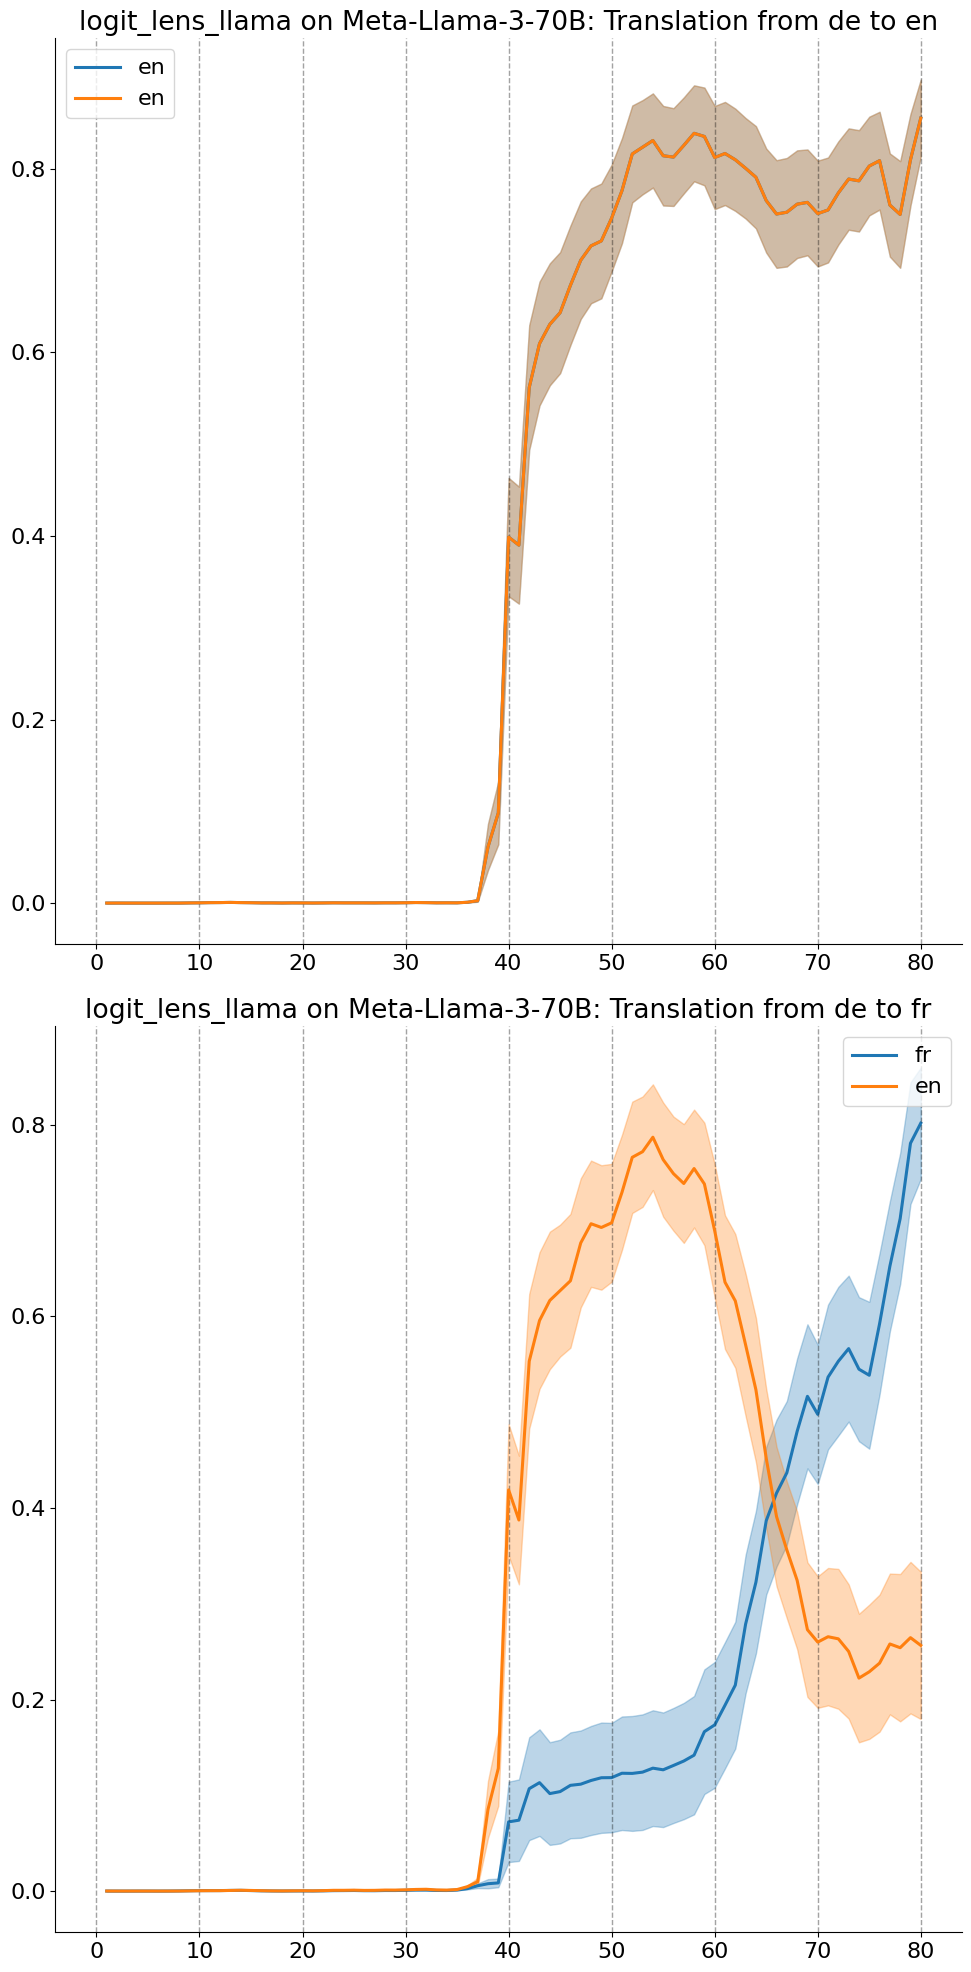

Found 120 translations


  0%|          | 0/120 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

Found 118 translations


  0%|          | 0/118 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

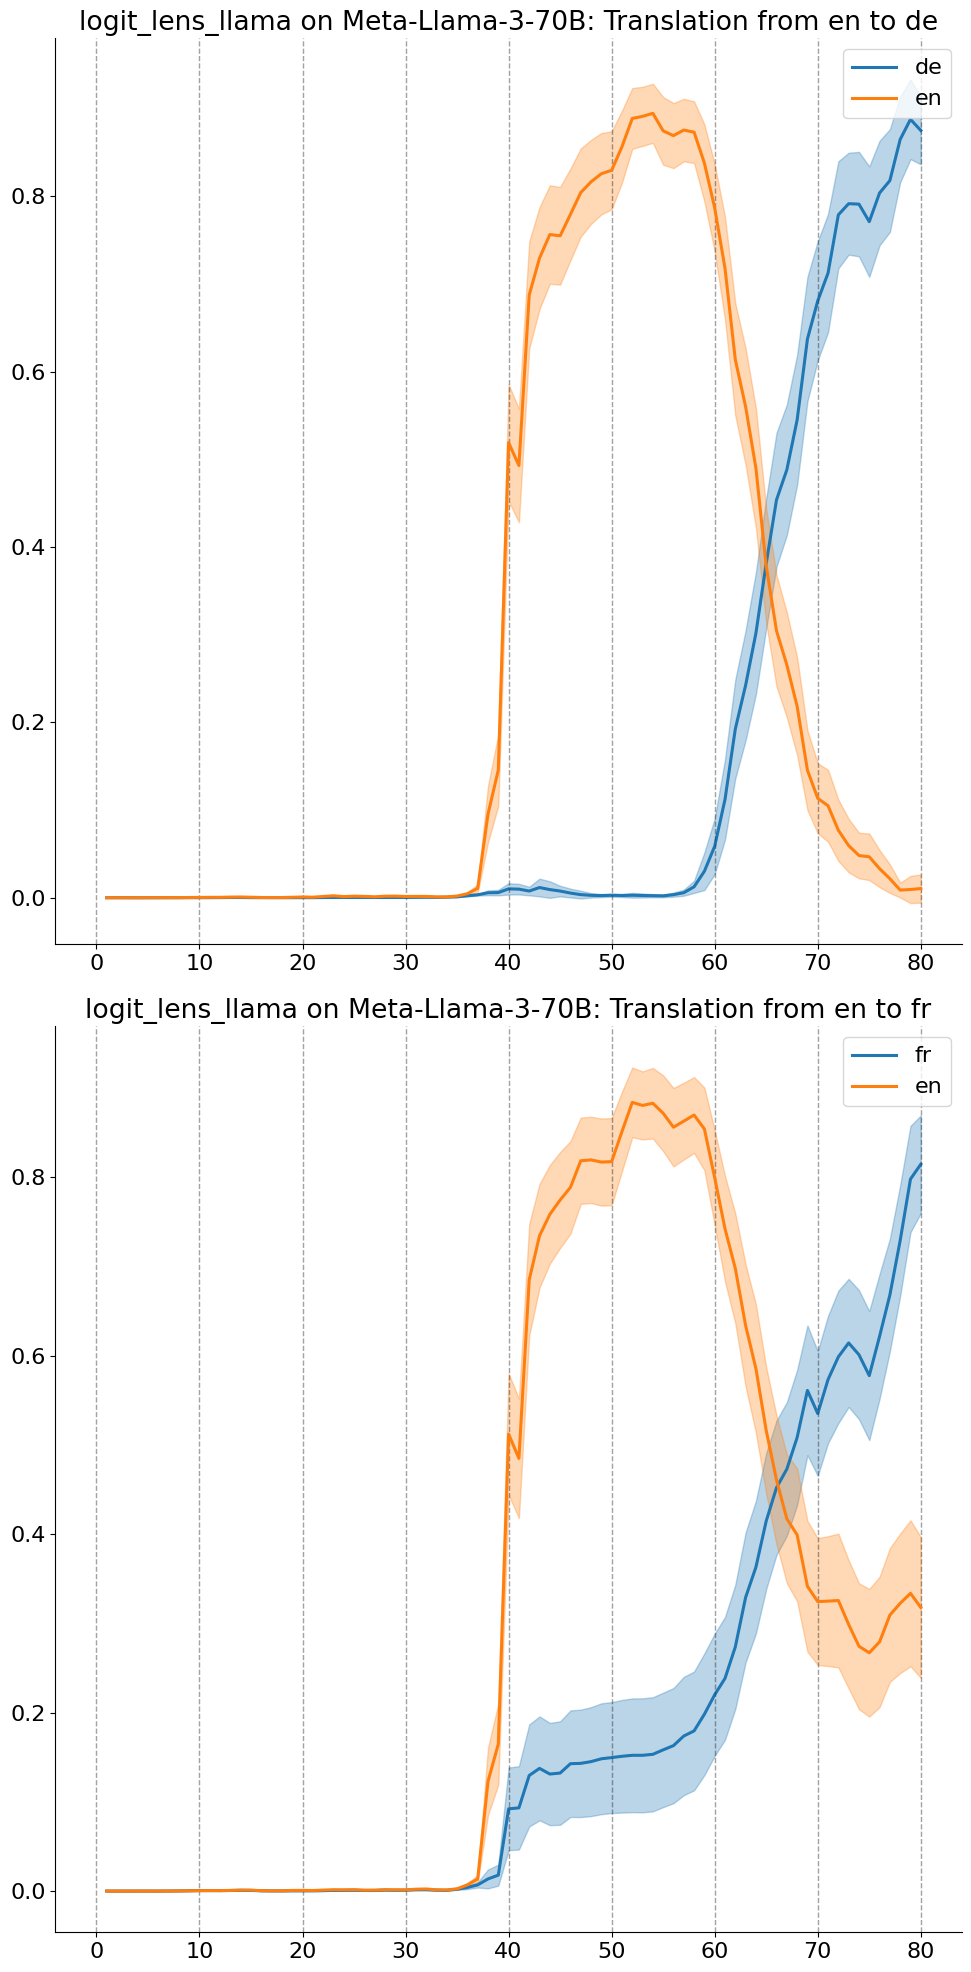

Found 109 translations


  0%|          | 0/109 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/7 [00:00<?, ?it/s]

Found 118 translations


  0%|          | 0/118 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

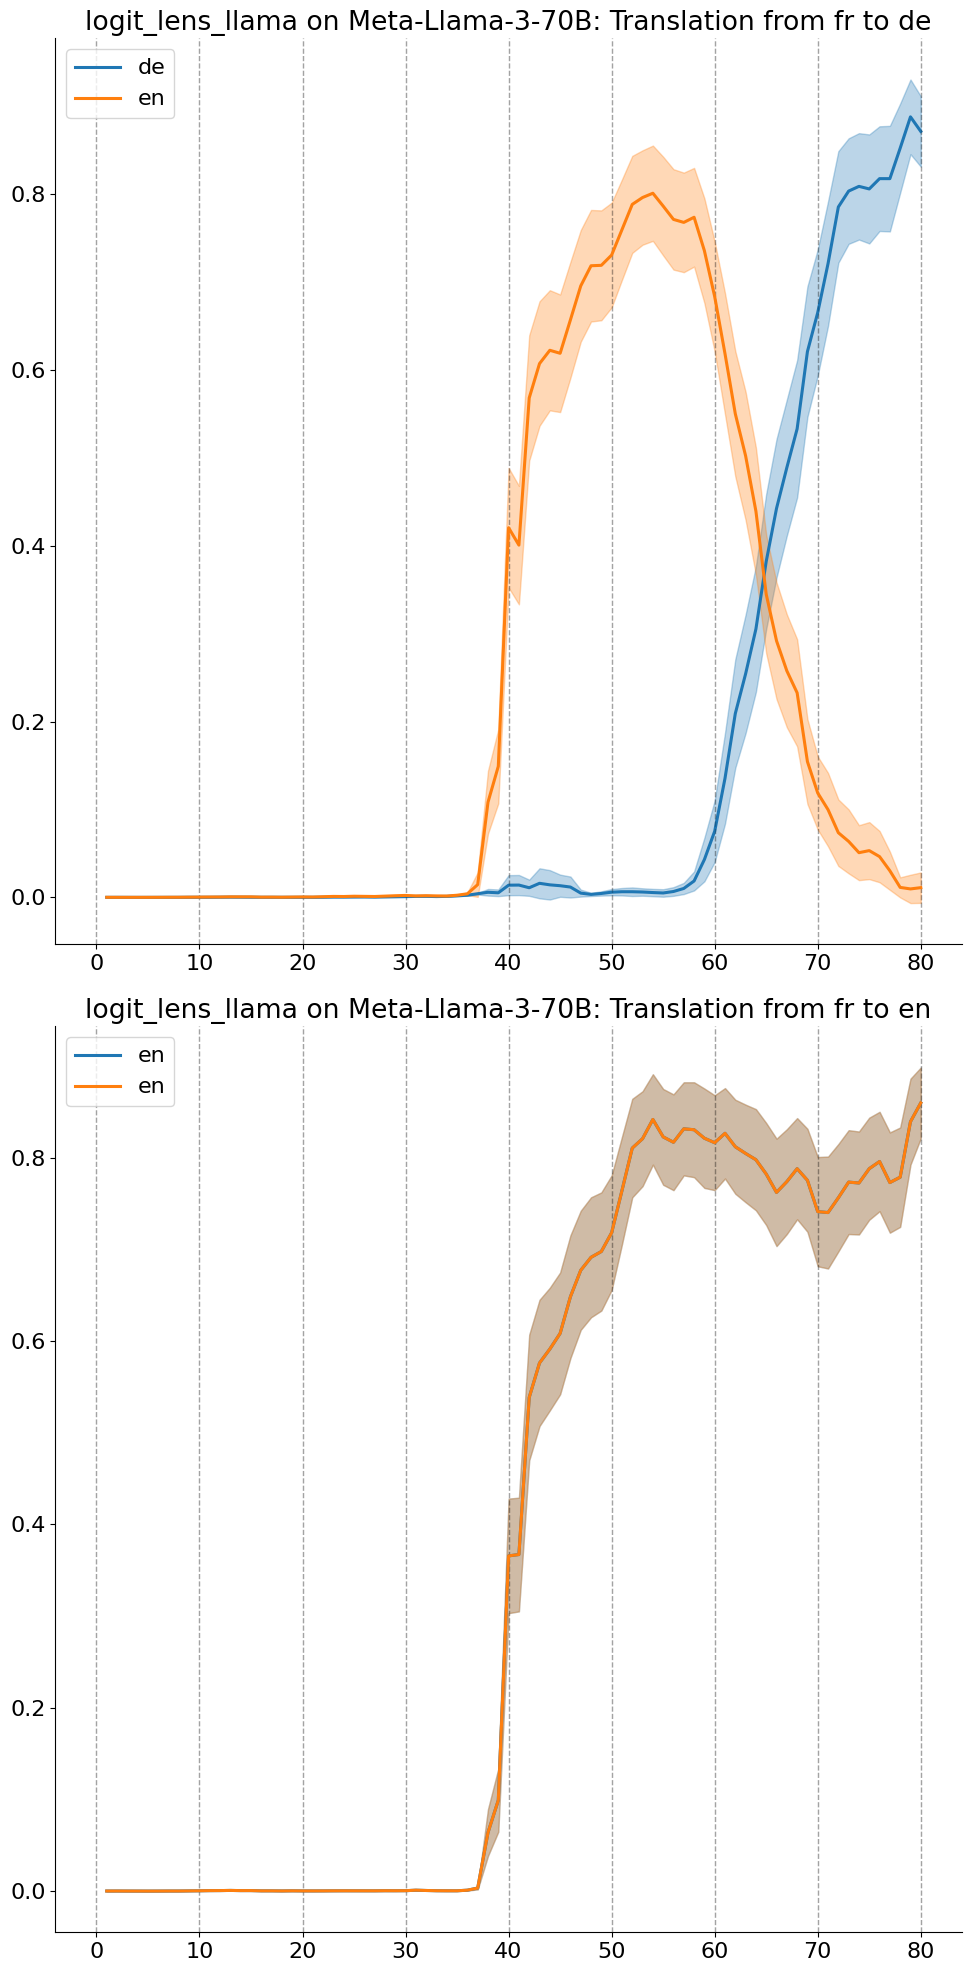

Found 105 translations


  0%|          | 0/105 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/7 [00:00<?, ?it/s]

Found 114 translations


  0%|          | 0/114 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

Found 104 translations


  0%|          | 0/104 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/7 [00:00<?, ?it/s]

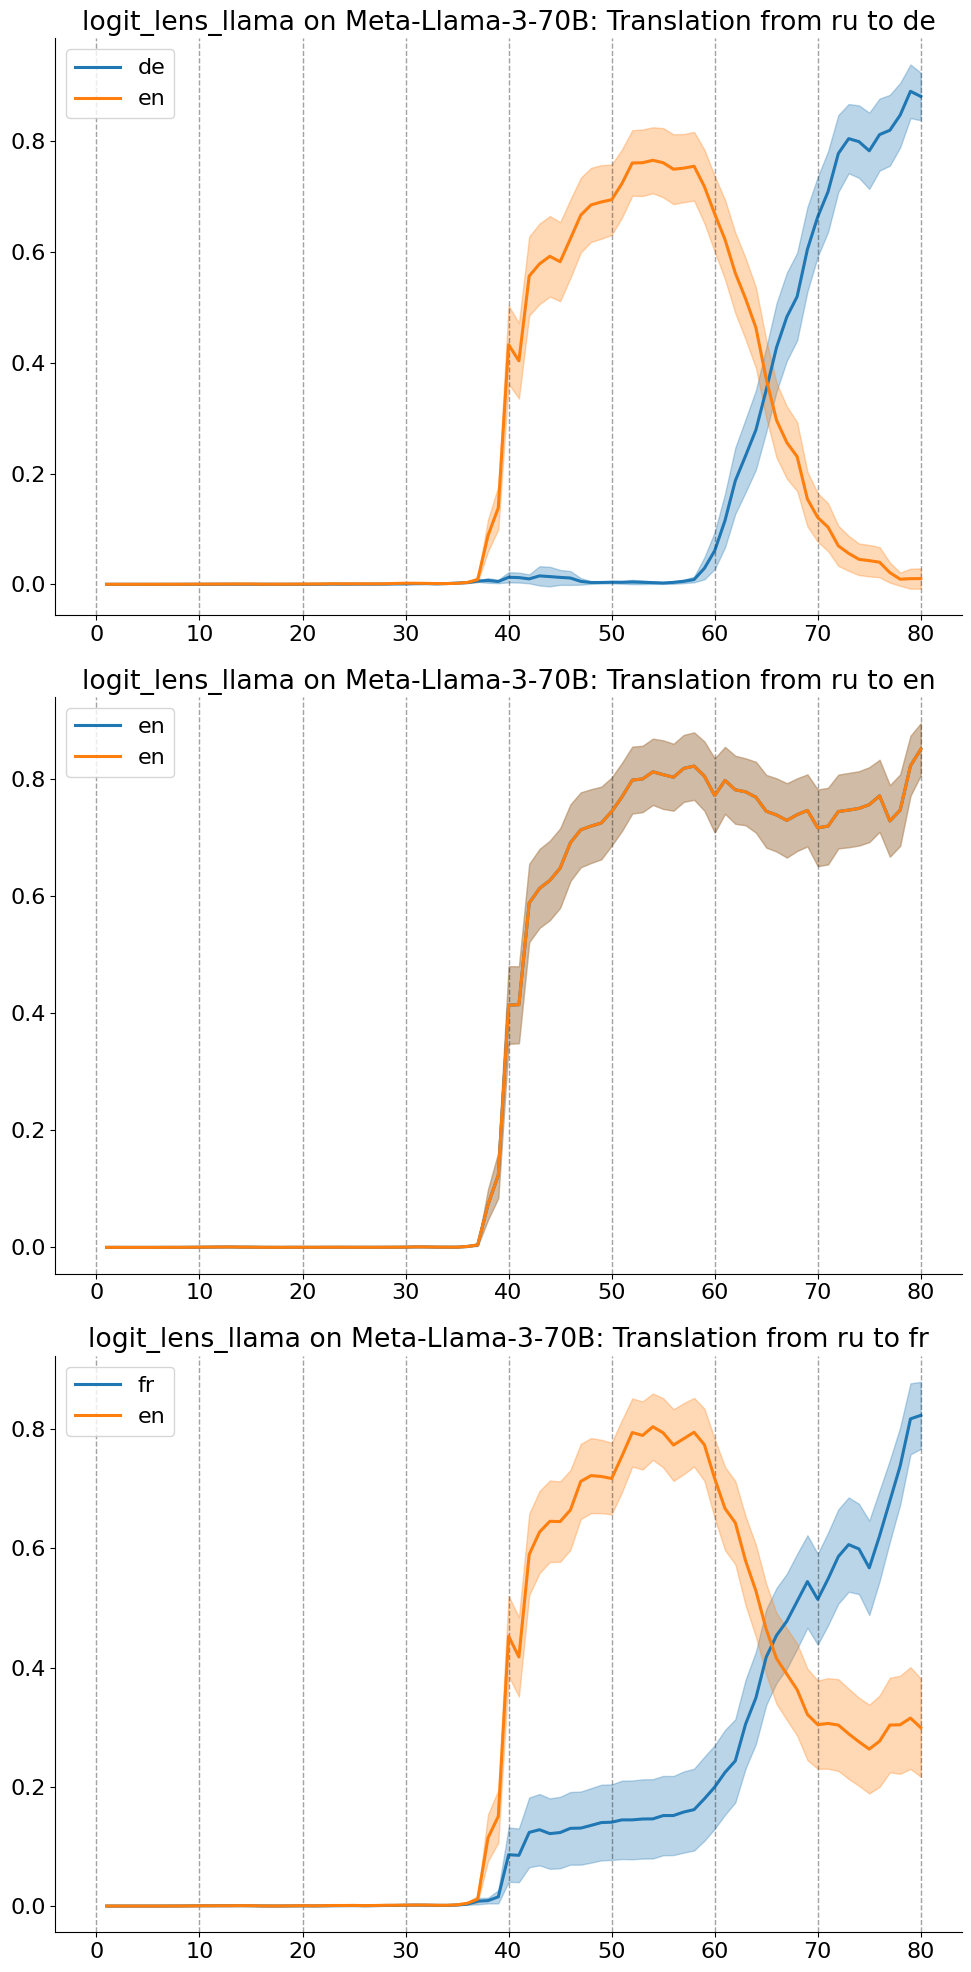

Found 120 translations


  0%|          | 0/120 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

Found 132 translations


  0%|          | 0/132 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/9 [00:00<?, ?it/s]

Found 118 translations


  0%|          | 0/118 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

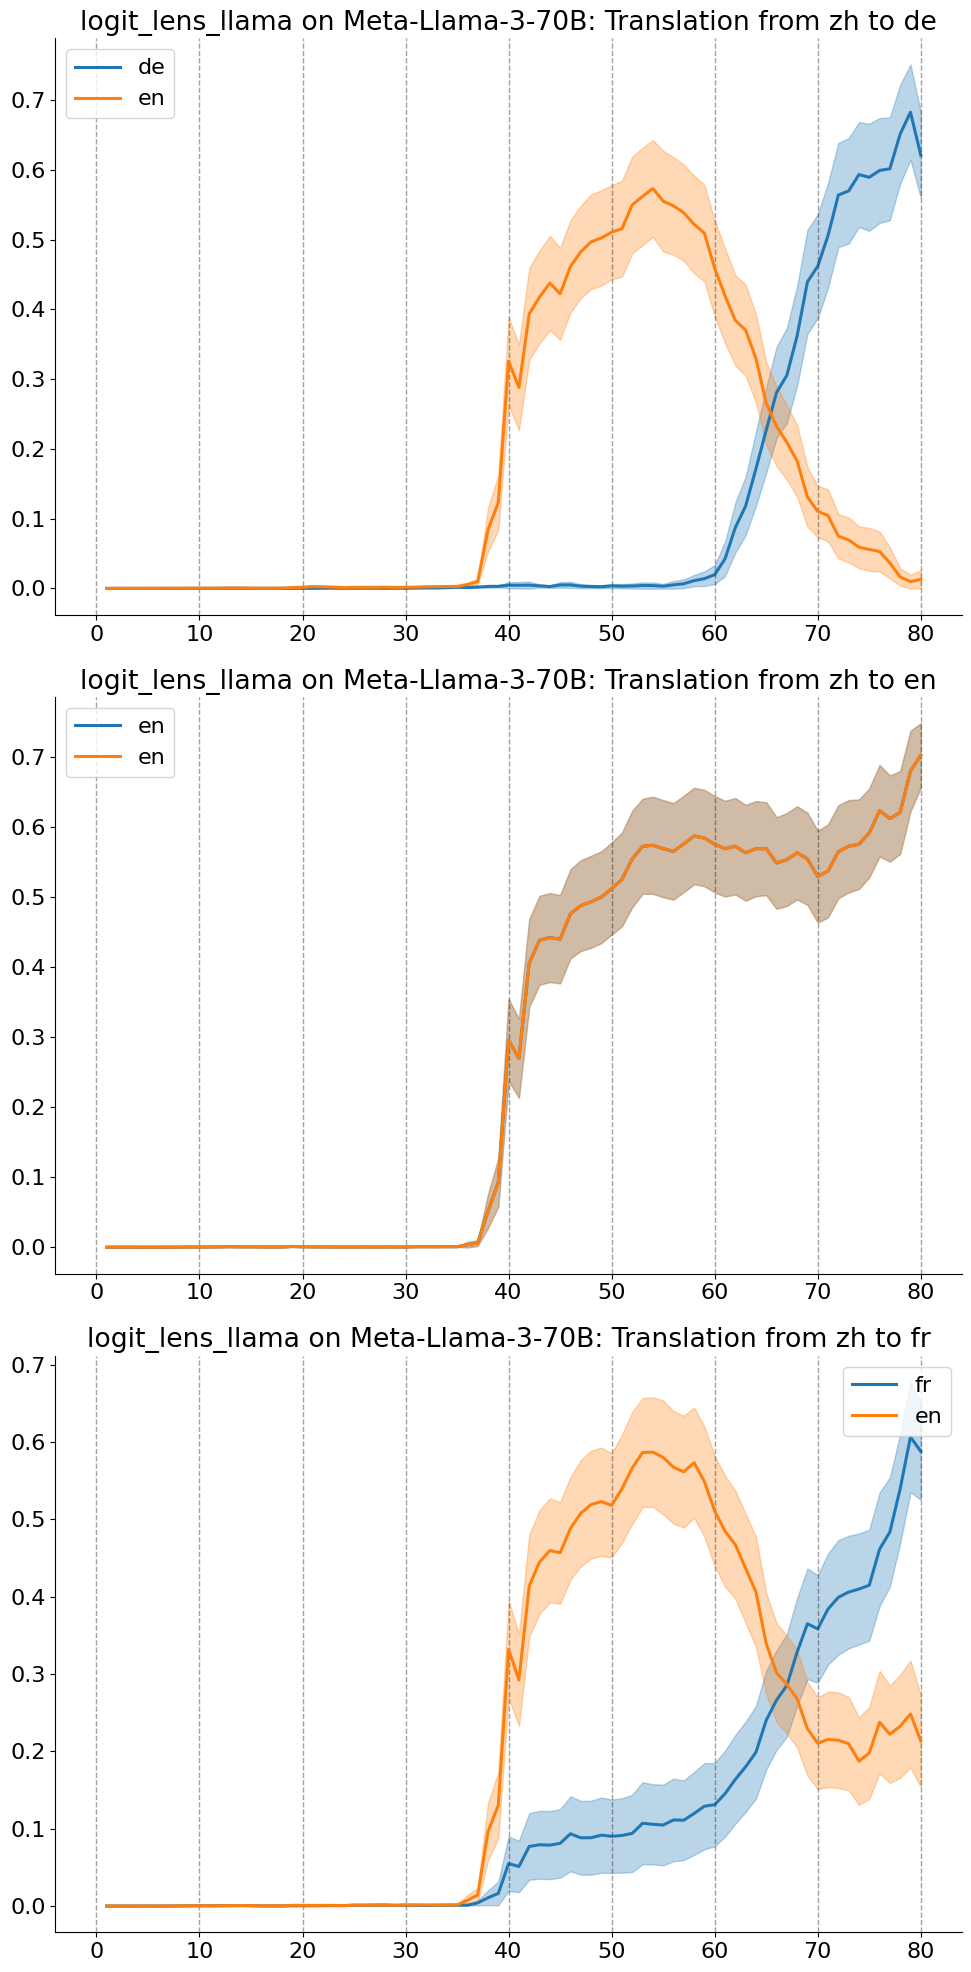

In [6]:
id_t = int(time())
path = Path(f"results/{model}/trans_{id_t}")
path.mkdir(parents=True, exist_ok=True)
for lang in from_langs:
    # Create a 4 line, 1 column plot
    fig, ax = plt.subplots(len(to_langs) - (lang in to_langs), 1, figsize=(10, 20))
    i = 0
    for target_lang in to_langs:
        if lang == target_lang:
            continue
        translation_plot(lang, target_lang, ["en"], ax=ax[i], batch_size=16)
        i += 1
    plt.tight_layout()
    plt.savefig(path / f"{lang}_to_all.png")
    plt.show()

## Multiword Translation

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Found 125 translations


  0%|          | 0/125 [00:00<?, ?it/s]

Running prompts:   0%|          | 0/8 [00:00<?, ?it/s]

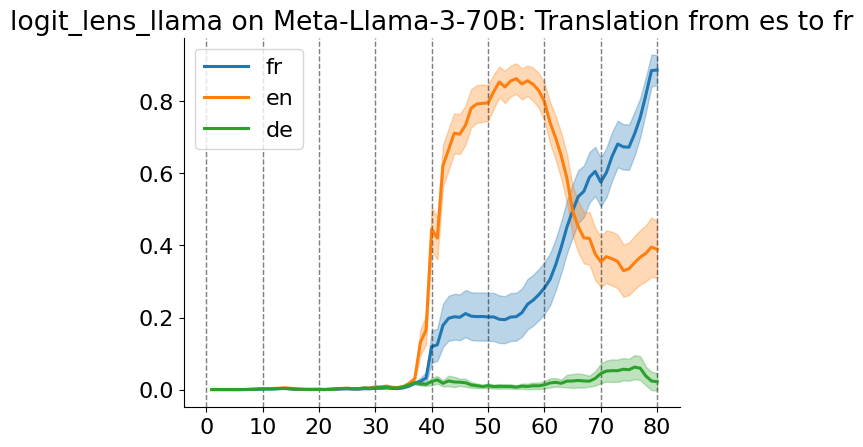

In [7]:
from translation_tools import get_wr_dataset as get_translations

translation_plot("es", "fr", ["en", "de"])